In [ ]:
# 数据读取，继承dataset类
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset
from torchvision import transforms

# label为0-10，分别代表了下列标签：
label_names=['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']
# 数据转换器
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    # 单通道归一化                          
    transforms.Normalize((0.5,),(0.5,))])

# dataset类，方便datasetloader读取并输入网络中
class MyDataset(Dataset):
    def __init__(self, label_index, transform = data_transforms):
        path = "data/quick_draw_data/"+label_names[label_index]+"/"+label_names[label_index]+".npy" 
        self.data = np.load(path)
        self.labels = [label_index]*len(self.data)
        self.transform = transform
        
        # 显示前10个图像
        plt.figure() # 新建画布，防止堆叠
        for i in range(10):
            plt.subplot(1,10,i+1)
            data = self.data[i,:]
            data = data.reshape( 28, 28)  #将数据转为（28，28）维度
            img = Image.fromarray(data)  #转为图片
            plt.imshow(img)
            plt.title(label_names[label_index])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        image = Image.fromarray(data.reshape(28,28))  #将数据转为（28，28）维度
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# 批量读取数据并整合为一个数据集
datasets = [MyDataset(label_index) for label_index in range(10)]
combined_dataset = ConcatDataset(datasets)  # 整的数据集

# 数据划分，得到train_set, val_set, test_set
from torch.utils.data import random_split

lengths = [int(len(combined_dataset)*0.6), int(len(combined_dataset)*0.3), int(len(combined_dataset)*0.1)]
train_set, val_set, test_set = random_split(combined_dataset, lengths)

# 构建CNN作为10-分类模型
from torch import nn
from torch.nn import Sequential, Conv2d, ReLU, MaxPool2d, Linear

class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net, self).__init__()
        self.conv1 = Sequential(
            Conv2d(1, 10, kernel_size=5),
            MaxPool2d(2),
            ReLU()
        )
        self.conv2 = Sequential(
            Conv2d(10, 20, kernel_size=5),
            MaxPool2d(2),
            ReLU()
        )
        
        self.fc = Linear(320, num_classes)     
    
    # 前向过程
    def forward(self,x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(batch_size, -1)  # Flatten
        x = self.fc(x)
        return x

# 训练模型
对模型进行训练，绘制训练过程中损失函数和预测acc曲线（在同一幅图中）

# 训练模型（单次，epoch_num为当前批次）
def train(epoch_num):
    print("当前批次：[%d]:" % (epoch_num+1))
    running_loss = 0.0
    loss_sum = 0.0
    for j,(batch_data,batch_label) in enumerate(train_loader):
        batch_data,batch_label=batch_data.to(device),batch_label.to(device)
        
        optimizer.zero_grad()
        output = model(batch_data)
        loss = loss_func(output, batch_label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # 每500次打印一次loss
        if (j+1) % 1000 == 0:
            print('loss:%.3f' % (running_loss / (1000*64)))
            loss_sum += running_loss
            running_loss = 0.0
    torch.save(model, "models/model_{}.pth".format(epoch_num))
    return loss_sum/len(train_set)

# 测试模型
def test():
    correct=0
    total=0
    with torch.no_grad():
        for batch_data,batch_label in test_loader:
            batch_data,batch_label=batch_data.to(device),batch_label.to(device)
            output = model(batch_data)
            _,predicted=torch.max(output.data,dim=1)
            total+=batch_label.size(0)
            correct+=(predicted==batch_label).sum().item()
    print('Accuracy on test set:%.3f %% [%d in %d]' %(correct/total,correct,total))
    return correct/total

from torch import optim
from torch.utils.data import DataLoader

model = Net()       # 创建模型
device = torch.device("cpu")
model.to(device)

batch_size = 64     # 批量训练大小
epoch_num = 10
learn_rate = 0.01 
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.5)

# 数据加载器
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set,batch_size, shuffle=True)
    
loss_set = []
acc_set = []


for epoch in range(10):
    loss = train(epoch)
    acc = test()
    loss_set.append(loss)
    acc_set.append(acc)

plt.plot(loss_set)
plt.plot(acc_set)
plt.show()

# 验证模型
从验证集中随机抽取10张图片进行预测，输出该图像的标签以及预测概率分布的柱状图

# 验证模型
label_names=['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']
val_loader = DataLoader(val_set,10, shuffle=True)

# 数据均为十个一组
def result_show(data,label,prediction):
    for i in range(10):
        plt.figure()
        
        plt.subplot(1,2,1)
        img = data[i].reshape(28,28)
        _,index = torch.max(prediction[i].data,dim=0)
#         print(index.data)
        plt.title("predict:{},ture:{}".format(label_names[index],label_names[label[i]]))
        plt.imshow(img)
        
        plt.subplot(1,2,2)
        plt.bar(range(len(prediction[i].data)), prediction[i].data)
        
    plt.show()

for i,(data,label) in enumerate(val_loader):
    if (i == 2):
        break
    prediction = model(data)
    result_show(data,label,prediction)




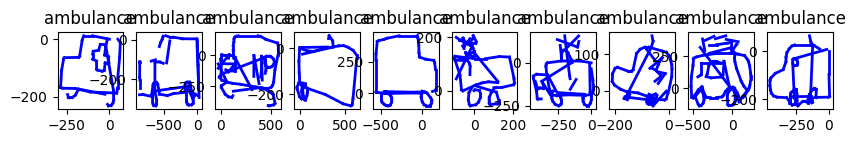

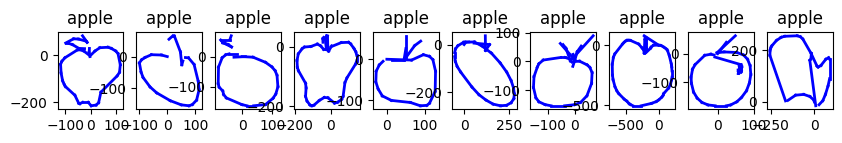

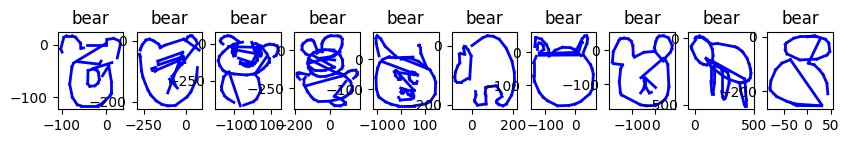

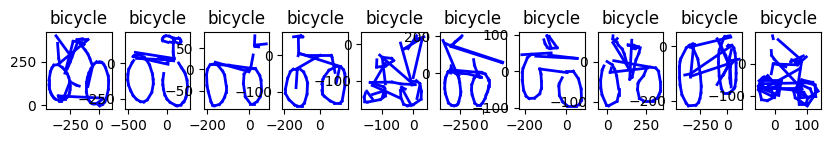

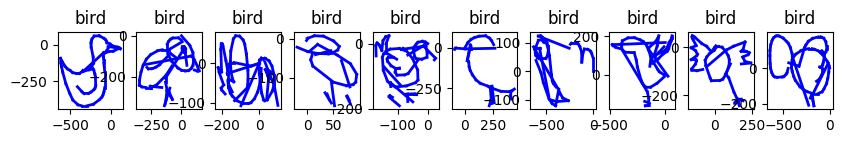

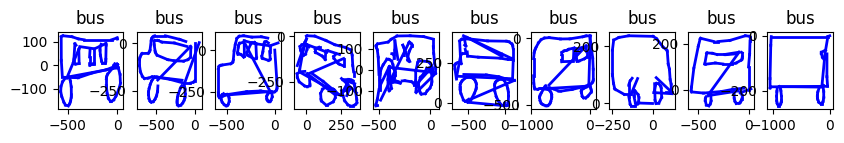

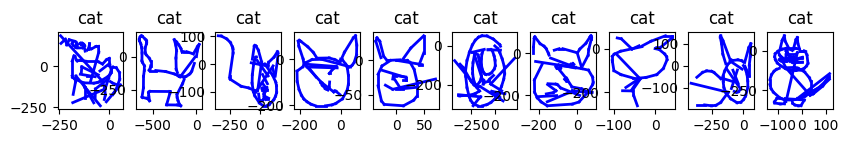

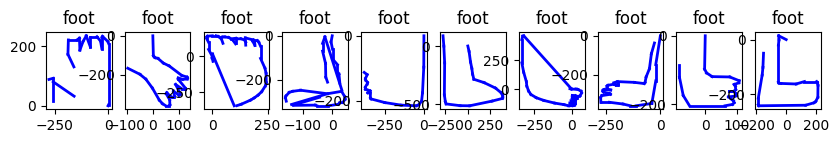

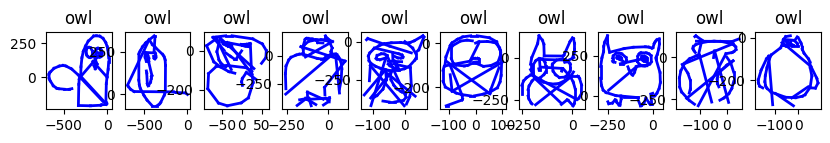

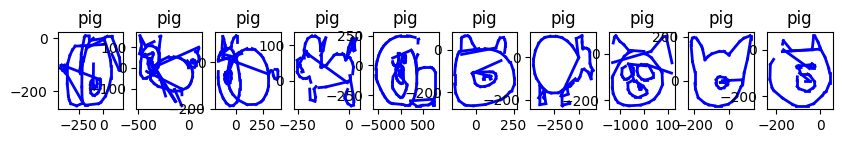

In [36]:
# 数据读取，继承dataset类
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset
from torchvision import transforms

import matplotlib.pyplot as plt
# label为0-10，分别代表了下列标签：
label_names=['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']

# 依据点序列数据绘制图像
def data_show(data):
    #  起点
    x1 =0
    y1 =0
    for i in range(len(data)):
        # 终点
        x2 = x1 - data[i,0]
        y2 = y1 - data[i,1]
        if data[i,2] == 1:
            plt.plot([x1,x2],[y1,y2], color="blue", linewidth=2)
            x1 = x2
            y1 = y2
        if data[i,3] == 1:
            x1 = x2
            y1 = y2
        if data[i,4] == 1:
            break

# dataset类，方便datasetloader读取并输入网络中
class MyDataset(Dataset):
    def __init__(self, label_index):
        path = "data/sketch_datas/"+label_names[label_index]+".npy" 
        self.data = np.load(path)
        # 绘制前十张图像
        plt.figure(figsize=(10,1))
        for i in range(10):
            plt.subplot(1,10,i+1)
            data_show(self.data[i])
            plt.title(label_names[label_index])
        plt.show()
        
        self.labels = [label_index]*len(self.data)
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        
        if len(data) >= 256:
            data = data[:256]  # 截断数组，只保留前256个元素
        else:
            num = 256 - len(data)
            padding = np.zeros((num, 5),dtype=data.dtype)# 填充数组
            data = np.vstack((data, padding))
        
#         print(len(data))
        data = self.transform(data)
#         data = torch.LongTensor(data)
        label = self.labels[idx]
        return data, label

# 批量读取数据并整合为一个数据集
datasets = [MyDataset(label_index) for label_index in range(10)]
combined_dataset = ConcatDataset(datasets)  # 整的数据集

In [2]:
# 数据划分，得到train_set, val_set, test_set
from torch.utils.data import random_split

lengths = [int(len(combined_dataset)*0.6), int(len(combined_dataset)*0.3), int(len(combined_dataset)*0.1)]
train_set, val_set, test_set = random_split(combined_dataset, lengths)

# BiLSTM网络

In [30]:
from torch import nn

# 定义BiLSTM编码器模型
class BiLSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # (batch_size, sequence_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        out = nn.functional.softmax(out, dim=1)  # softmax分类
        return out

In [31]:
from torch import optim
from torch.utils.data import DataLoader

seq_length = 256
input_size = 5
# 定义模型参数
hidden_size = 64
num_layers = 2
num_classes = 10

model = BiLSTMEncoder(input_size, hidden_size, num_layers,num_classes)
device = torch.device("cpu")
model.to(device)

batch_size = 32     # 批量训练大小
epoch_num = 10
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 数据加载器
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set,batch_size, shuffle=True)
    
loss_set = []
acc_set = []

In [34]:
# 训练模型（单次，epoch_num为当前批次）
def train(epoch_num):
    print("当前批次：[%d]:" % (epoch_num+1))
    running_loss = 0.0
    loss_sum = 0.0
    for j,(batch_data,batch_label) in enumerate(train_loader):
        batch_data,batch_label=batch_data.to(device),batch_label.to(device)
        batch_data = batch_data.squeeze(dim=1).float()  # 去除维度为 1 的维度
        
        optimizer.zero_grad()
        output = model(batch_data)
        loss = loss_func(output, batch_label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # 每500次打印一次loss
        if (j+1) % 1000 == 0:
            print('loss:%.3f' % (running_loss / (1000*32)))
            loss_sum += running_loss
            running_loss = 0.0
    torch.save(model, "models/model2_{}.pth".format(epoch_num))
    return loss_sum/len(train_set)

# 测试模型
def test():
    correct=0
    total=0
    with torch.no_grad():
        for batch_data,batch_label in test_loader:
            batch_data,batch_label=batch_data.to(device),batch_label.to(device)
            batch_data = batch_data.squeeze(dim=1).double()  # 去除维度为 1 的维度
            
            output = model(batch_data)
            _,predicted=torch.max(output.data,dim=1)
            total+=batch_label.size(0)
            correct+=(predicted==batch_label).sum().item()
    print('Accuracy on test set:%.3f %% [%d in %d]' %(correct/total,correct,total))
    return correct/total

In [35]:
for epoch in range(10):
    loss = train(epoch)
    acc = test()
    loss_set.append(loss)plt.title("predict:{},ture:{}".format(label_names[index],label_names[label[i]]))
    acc_set.append(acc)

当前批次：[1]:
loss:0.072
loss:0.072
loss:0.072
loss:0.072
loss:0.072
loss:0.072
loss:0.072
loss:0.072


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_set)
plt.plot(acc_set)
plt.show()

# 验证模型
label_names=['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']
val_loader = DataLoader(val_set,10, shuffle=True)

# 数据均为十个一组
def result_show(data,label,prediction):
    for i in range(10):
        plt.figure()
        
        plt.subplot(1,2,1)
             data= data[i]
        _,index = torch.max(prediction[i].data,dim=0)

        data_show(self.data[i])
        plt.title("predict:{},ture:{}".format(label_names[index],label_names[label[i]]))
        plt.subplot(1,2,2)
        plt.bar(range(len(prediction[i].data)), prediction[i].data)
    plt.show()

for i,(data,label) in enumerate(val_loader):
    if (i == 2):
        break
    prediction = model(data)
    result_show(data,label,prediction)